In [1]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import subprocess
from joblib import Parallel, delayed
import dask.array as da
import regionmask
import matplotlib.colors as mcolors

In [2]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('figures'):
    os.makedirs('figures')
if not os.path.exists('data'):
    os.makedirs('data')

In [3]:
download = False

## Load Data

In [4]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip_fcast.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip_fcast.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip_fcast.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip_fcast.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip_fcast.nc'

nasageos_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos_path = 'download/nasageos_precip_fcast.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos_url, '-o', nasageos_path])

    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    

In [5]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos_path, decode_times=True)
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

In [6]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')
#convert T to pd.datetime
obs_3m['T'] = pd.to_datetime(obs_3m['T'].values, format="%d-%m-%Y")


https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [7]:
spi_obs = xr.load_dataset('../data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')
spi_obs['T'] = pd.to_datetime(spi_obs['T'].values, format="%Y-%m-%d")


landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    spi_obs.X, spi_obs.Y
)


## Forecast

In [8]:
nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cesm1': cesm1, 'colaccsm4': colaccsm4, 'nasageos': nasageos}

In [9]:
# First, concatenate all members from all NMME models
print("Concatenating all NMME members...")
all_nmme_data = []
all_member_names = []

for (nmme_name, nmme) in nmme_dict.items():
    print(f"Adding members from {nmme_name}")
    # Add model name to member names for identification
    members = nmme['M'].values
    for member in members:
        member_id = f"{nmme_name}_{member}"
        all_member_names.append(member_id)
        all_nmme_data.append(nmme.sel(M=member))

# Concatenate all members across models
print(f"Total members across all models: {len(all_member_names)}")
combined_nmme = xr.concat(all_nmme_data, dim='M')
combined_nmme = combined_nmme.assign_coords(M=all_member_names)


Concatenating all NMME members...
Adding members from cfsv2
Adding members from gfdlspear
Adding members from cesm1
Adding members from colaccsm4
Adding members from nasageos
Total members across all models: 88


In [10]:
from scipy.stats import pearson3, norm
def compute_spi_pearson3(da, dim='S'):
    """
    Compute SPI (Standardized Precipitation Index) using Pearson Type III distribution
    along the specified time dimension.
    """
    def _spi_1d(x):
        x = np.asarray(x, dtype=float)
        mask = np.isfinite(x)

        if mask.sum() < 3 or np.all(x[mask] <= 0):
            return np.full_like(x, np.nan, dtype=float)

        try:
            skew, loc, scale = pearson3.fit(x[mask])
            cdf = pearson3.cdf(x[mask], skew, loc=loc, scale=scale)
            spi_vals = norm.ppf(cdf)
            out = np.full_like(x, np.nan, dtype=float)
            out[mask] = spi_vals
            return out
        except Exception:
            return np.full_like(x, np.nan, dtype=float)

    # Apply along time dimension
    spi = xr.apply_ufunc(
        _spi_1d,
        da,
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],   # preserve time dim
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

    return spi

In [11]:
fcst = combined_nmme.prec.sel(
    S=slice('1991-01-01', '2025-12-31'),
    L=slice(0.5, 2.5), # Must include 0.5, 1.5, and 2.5 for the 3-month sum
)

In [12]:
n_cat = 3
ref_probs = np.ones(n_cat) / n_cat

forecast_probs_list = []

TARGET_LEAD_INDEX = 2  # corresponds to L=2.5
target_start = pd.Timestamp("2024-12-01")
target_end   = pd.Timestamp("2025-05-31")

# --- Outer loop: iterate over each forecast start date ---
for s_date in fcst.S.values:
    s_date = pd.Timestamp(s_date)
    s_month = s_date.month

    # Compute valid (target) time for this lead
    valid_time = s_date + pd.DateOffset(months=TARGET_LEAD_INDEX)
    if not (target_start <= valid_time <= target_end):
        continue  

    print(f"Processing start date {s_date:%Y-%m}, valid {valid_time:%Y-%m}")

    # --- Select all forecasts for same start month up to and including current start date ---
    fcst_same_month = fcst.sel(S=fcst["S.month"] == s_month)
    fcst_hist = fcst_same_month.sel(S=fcst_same_month["S"] <= s_date)

    if fcst_hist.S.size < 10:  # require some history
        print(f"   Skipping {s_date:%Y-%m}: not enough historical starts for climatology")
        continue

    # --- Sum over 3-month window (lead-2, lead-1, lead) ---
    fcst_hist_sum = (
        fcst_hist.isel(L=TARGET_LEAD_INDEX)
        + fcst_hist.isel(L=TARGET_LEAD_INDEX - 1)
        + fcst_hist.isel(L=TARGET_LEAD_INDEX - 2)
    )

    # --- Compute SPI for entire historical forecast record ---
    spi_hist = compute_spi_pearson3(fcst_hist_sum, dim="S")

    # Extract the last SPI value (the forecast for this start date)
    spi_fcst = spi_hist.isel(S=-1)

    # --- Compute tercile thresholds from full SPI climatology ---
    q33 = spi_hist.quantile(0.33, dim=["M", "S"], skipna=True).drop_vars("quantile", errors="ignore")
    q67 = spi_hist.quantile(0.67, dim=["M", "S"], skipna=True).drop_vars("quantile", errors="ignore")

    q33_b = q33.broadcast_like(spi_fcst)
    q67_b = q67.broadcast_like(spi_fcst)

    # --- Category masks ---
    mask_below = spi_fcst < q33_b
    mask_near  = (spi_fcst >= q33_b) & (spi_fcst <= q67_b)
    mask_above = spi_fcst > q67_b

    # --- Ensemble probabilities ---
    below = mask_below.mean(dim="M", skipna=True)
    near  = mask_near.mean(dim="M", skipna=True)
    above = mask_above.mean(dim="M", skipna=True)

    prob = xr.concat([below, near, above], dim="category").assign_coords(category=[0, 1, 2])

    # --- Mask invalid regions / missing obs ---
    obs_valid = spi_obs.sel(T=[valid_time])
    prob = prob.where(obs_valid.notnull(), drop=False)
    prob = prob.where(landmask == 0)

    # --- Assign time coords ---
    prob = prob.assign_coords(T=("T", [valid_time]), Smonth=s_month)

    forecast_probs_list.append(prob)

# --- Combine all results ---
forecast_probs_final = xr.concat(forecast_probs_list, dim="T").sortby("T")



Processing start date 2024-10, valid 2024-12
Processing start date 2024-11, valid 2025-01
Processing start date 2024-12, valid 2025-02
Processing start date 2025-01, valid 2025-03
Processing start date 2025-02, valid 2025-04
Processing start date 2025-03, valid 2025-05


In [13]:
forecast_probs_final.to_netcdf('data/spi_prob_fcast.nc')

# Skill

In [14]:
spi_prob_forecast = xr.open_dataarray('data/spi_prob_fcast.nc')

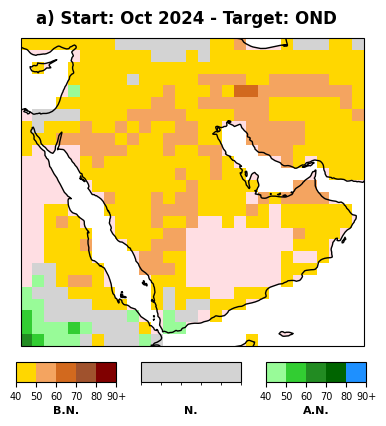

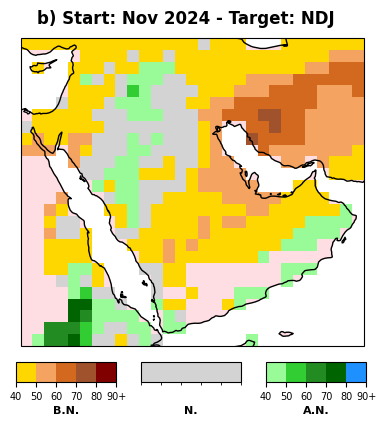

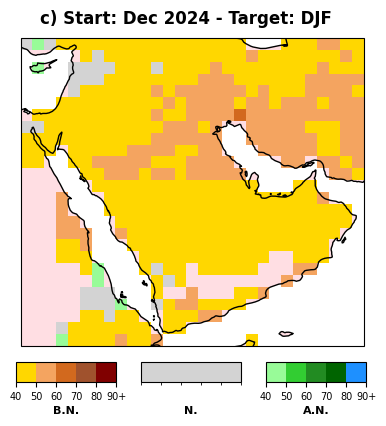

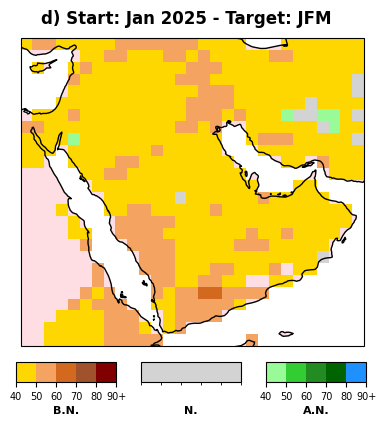

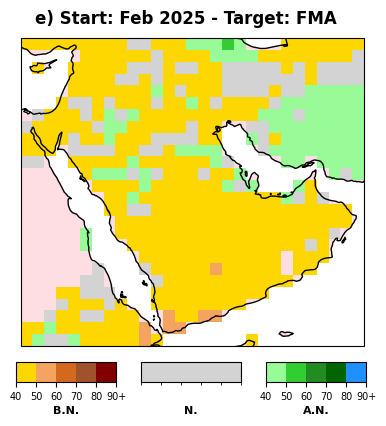

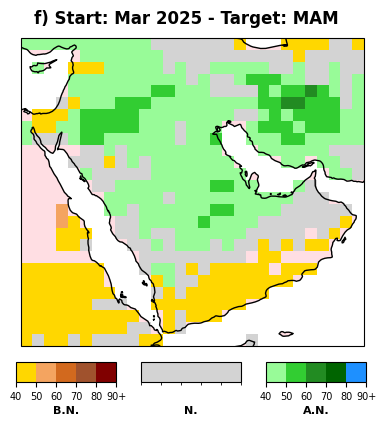

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm, to_rgba


# --- Labels for seasons ---
seasons_to_label = {"OND":"a)", "NDJ":"b)", "DJF":"c)", "JFM":"d)", "FMA":"e)", "MAM":"f)",
                    "AMJ":"g)", "MJJ":"h)", "JJA":"i)", "JAS":"j)", "ASO":"k)", "SON":"l)"}
seasons = ["NDJ", "DJF", "JFM", "FMA", "MAM", "AMJ", "MJJ", "JJA", "JAS", "ASO", "SON", "OND"]

# --- Define specific color palettes for each category ---
cat_labels = ["Below Normal", "Normal", "Above Normal"]

# --- Discrete probability bins ---
bounds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.90]
n_bins = len(bounds) - 1

# Define specific colors for each category
bn_colors = ["gold", "sandybrown", "chocolate", "sienna", "maroon"]
normal_colors = ["lightgray"]
an_colors = ["palegreen", "limegreen", "forestgreen", "darkgreen", "dodgerblue"]

cat_color_gradients = [bn_colors, normal_colors, an_colors]

for start in spi_prob_forecast['S'].values:

    target = start + pd.DateOffset(months=int(2.5 - 0.5))


    prob_fcast_sl = spi_prob_forecast.sel(T = target)

    target_date = start + pd.DateOffset(months=int(2.5 - 0.5))
    if target_date > spi_obs['T'].values[-1]:
        continue


    # --- Identify dominant category ---
    dominant_cat = prob_fcast_sl.fillna(0).argmax(dim="category")

    target_month = pd.to_datetime(target_date).month
    target_season = seasons[target_month - 1]
    label = seasons_to_label[target_season]

    fig, ax = plt.subplots(
        1, 1, figsize=(5, 4),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    ims = []
    for i, colors in enumerate(cat_color_gradients):
        prob_dom_only = prob_fcast_sl.isel(category=i).where(dominant_cat == i)

        # Create colormap with specific colors for this category
        cmap_specific = ListedColormap(colors)
        norm = BoundaryNorm(bounds, ncolors=n_bins)

        im = ax.pcolormesh(
            prob_fcast_sl['X'], prob_fcast_sl['Y'],
            prob_dom_only,
            cmap=cmap_specific, norm=norm,
            transform=ccrs.PlateCarree()
        )
        ims.append(im)

    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="lightpink", alpha=0.45)

    # --- Discrete colorbars (bottom, same placement as before) ---
    cbar_width = 0.2
    cbar_height = 0.05
    x_start = 0.16
    y_start = 0.02
    x_gap = 0.05
    labels_bottom = ["B.N.", "N.", "A.N."]

    for i, (lab, colors, im) in enumerate(zip(cat_labels, cat_color_gradients, ims)):
        cax = fig.add_axes([x_start + i*(cbar_width + x_gap),
                            y_start, cbar_width, cbar_height])

        # Special handling for Normal category (white) - no ticks or labels
        if i == 1:  # Normal category
            cb = fig.colorbar(
                im, cax=cax, orientation="horizontal",
                boundaries=bounds, spacing="uniform", ticks=[]
            )
        else:
            cb = fig.colorbar(
                im, cax=cax, orientation="horizontal",
                boundaries=bounds, spacing="uniform", ticks=bounds
            )
            cb.set_ticklabels(["40", "50", "60", "70", "80", "90+"])
            cb.ax.tick_params(labelsize=7)

        # add category label under each bar
        x_center = x_start + i*(cbar_width + x_gap) + cbar_width/2
        fig.text(x_center, y_start - 0.06, labels_bottom[i],
                 fontsize=8, fontweight='bold', ha='center', va='top')

    # --- Title ---
    plt.suptitle(
        f"{label} Start: {pd.to_datetime(start).strftime('%b %Y')} - Target: {target_season}",
        fontweight='bold', y=0.95
    )

    #add grid latitude and longitude lines but small fonts
    #gl = ax.gridlines(draw_labels=True)
    #gl.xlabels_top = False
    #l.ylabels_left = False
    #gl.xlabel_style = {'size': 8}
    #gl.ylabel_style = {'size': 8}

    plt.savefig(
        f"figures/spiV2_fcast_Target_{target_season}_Start_{pd.to_datetime(start).strftime('%b%Y')}.pdf",
        dpi=150, bbox_inches='tight', pad_inches=0.1
    )
    plt.show()